# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 2.9MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

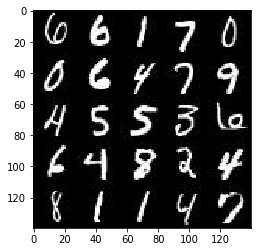

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

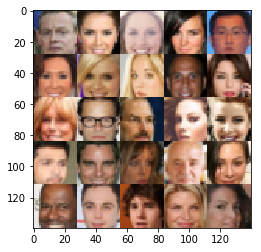

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2

    with tf.variable_scope('discriminator', reuse=reuse):
        
        # No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, 0.8)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, 0.8)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
        logits = tf.nn.dropout(logits, 0.8)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.2

    with tf.variable_scope('generator', reuse=not is_train):

        #fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, 'valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'same')      
        out = tf.tanh(logits)
        
    return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    w, h, c = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, rate = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, rate, beta1)
    
    save = tf.train.Saver()
    count = 0
    
       
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, rate: learning_rate})
                
                if count % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                
                if count % 200 == 0:
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                    
        save.save(sess, './savepoint.ckpt')
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3..., step 10 Discriminator Loss: 0.9805... Generator Loss: 0.8023
Epoch 1/3..., step 20 Discriminator Loss: 0.8382... Generator Loss: 1.0251
Epoch 1/3..., step 30 Discriminator Loss: 1.1040... Generator Loss: 0.9144
Epoch 1/3..., step 40 Discriminator Loss: 1.0283... Generator Loss: 1.0604
Epoch 1/3..., step 50 Discriminator Loss: 0.9452... Generator Loss: 1.1716
Epoch 1/3..., step 60 Discriminator Loss: 0.8414... Generator Loss: 1.2764
Epoch 1/3..., step 70 Discriminator Loss: 0.8523... Generator Loss: 1.1678
Epoch 1/3..., step 80 Discriminator Loss: 0.9438... Generator Loss: 1.1500
Epoch 1/3..., step 90 Discriminator Loss: 0.6834... Generator Loss: 1.7623
Epoch 1/3..., step 100 Discriminator Loss: 0.5794... Generator Loss: 1.8634
Epoch 1/3..., step 110 Discriminator Loss: 0.5091... Generator Loss: 1.8792
Epoch 1/3..., step 120 Discriminator Loss: 0.5614... Generator Loss: 1.8369
Epoch 1/3..., step 130 Discriminator Loss: 0.6914... Generator Loss: 1.6701
Epoch 1/3..., step 14

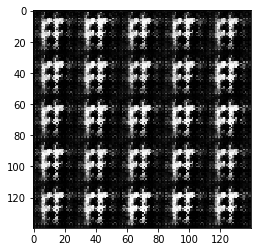

Epoch 1/3..., step 210 Discriminator Loss: 0.5910... Generator Loss: 2.2994
Epoch 1/3..., step 220 Discriminator Loss: 0.3164... Generator Loss: 2.7405
Epoch 1/3..., step 230 Discriminator Loss: 0.4924... Generator Loss: 2.2430
Epoch 1/3..., step 240 Discriminator Loss: 0.5015... Generator Loss: 1.8048
Epoch 1/3..., step 250 Discriminator Loss: 0.5048... Generator Loss: 2.6100
Epoch 1/3..., step 260 Discriminator Loss: 0.4032... Generator Loss: 2.7186
Epoch 1/3..., step 270 Discriminator Loss: 0.3126... Generator Loss: 2.4262
Epoch 1/3..., step 280 Discriminator Loss: 0.3495... Generator Loss: 2.6725
Epoch 1/3..., step 290 Discriminator Loss: 0.3513... Generator Loss: 2.4019
Epoch 1/3..., step 300 Discriminator Loss: 0.3771... Generator Loss: 2.4230
Epoch 1/3..., step 310 Discriminator Loss: 0.3951... Generator Loss: 2.0703
Epoch 1/3..., step 320 Discriminator Loss: 0.5739... Generator Loss: 1.6140
Epoch 1/3..., step 330 Discriminator Loss: 1.7107... Generator Loss: 5.7295
Epoch 1/3...

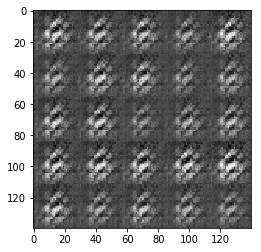

Epoch 1/3..., step 410 Discriminator Loss: 0.4806... Generator Loss: 2.2420
Epoch 1/3..., step 420 Discriminator Loss: 0.6125... Generator Loss: 1.8893
Epoch 1/3..., step 430 Discriminator Loss: 0.5402... Generator Loss: 2.2294
Epoch 1/3..., step 440 Discriminator Loss: 0.4146... Generator Loss: 2.1230
Epoch 1/3..., step 450 Discriminator Loss: 0.4685... Generator Loss: 2.2936
Epoch 1/3..., step 460 Discriminator Loss: 0.5344... Generator Loss: 1.7421
Epoch 1/3..., step 470 Discriminator Loss: 0.4534... Generator Loss: 1.9630
Epoch 1/3..., step 480 Discriminator Loss: 0.4505... Generator Loss: 2.0677
Epoch 1/3..., step 490 Discriminator Loss: 0.4368... Generator Loss: 2.2833
Epoch 1/3..., step 500 Discriminator Loss: 0.5610... Generator Loss: 1.5897
Epoch 1/3..., step 510 Discriminator Loss: 0.5484... Generator Loss: 1.8608
Epoch 1/3..., step 520 Discriminator Loss: 0.3867... Generator Loss: 2.3817
Epoch 1/3..., step 530 Discriminator Loss: 0.3726... Generator Loss: 2.8593
Epoch 1/3...

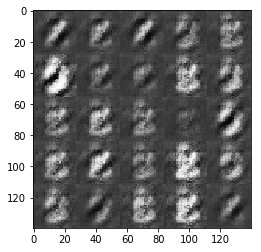

Epoch 1/3..., step 610 Discriminator Loss: 0.6182... Generator Loss: 1.8902
Epoch 1/3..., step 620 Discriminator Loss: 0.5772... Generator Loss: 2.0287
Epoch 1/3..., step 630 Discriminator Loss: 0.5585... Generator Loss: 1.3927
Epoch 1/3..., step 640 Discriminator Loss: 0.5201... Generator Loss: 2.4934
Epoch 1/3..., step 650 Discriminator Loss: 0.4759... Generator Loss: 1.5940
Epoch 1/3..., step 660 Discriminator Loss: 0.6666... Generator Loss: 1.1601
Epoch 1/3..., step 670 Discriminator Loss: 0.5916... Generator Loss: 1.4489
Epoch 1/3..., step 680 Discriminator Loss: 0.3663... Generator Loss: 3.1852
Epoch 1/3..., step 690 Discriminator Loss: 0.3972... Generator Loss: 2.2456
Epoch 1/3..., step 700 Discriminator Loss: 0.4147... Generator Loss: 2.1555
Epoch 1/3..., step 710 Discriminator Loss: 0.7025... Generator Loss: 1.3432
Epoch 1/3..., step 720 Discriminator Loss: 0.5618... Generator Loss: 1.8309
Epoch 1/3..., step 730 Discriminator Loss: 1.3000... Generator Loss: 0.4790
Epoch 1/3...

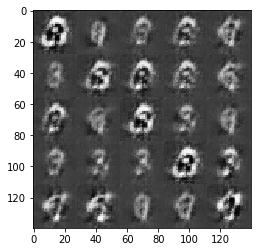

Epoch 1/3..., step 810 Discriminator Loss: 0.5290... Generator Loss: 1.5337
Epoch 1/3..., step 820 Discriminator Loss: 0.4911... Generator Loss: 1.4883
Epoch 1/3..., step 830 Discriminator Loss: 0.3801... Generator Loss: 4.0583
Epoch 1/3..., step 840 Discriminator Loss: 0.5228... Generator Loss: 2.0759
Epoch 1/3..., step 850 Discriminator Loss: 0.5490... Generator Loss: 2.9305
Epoch 1/3..., step 860 Discriminator Loss: 0.5287... Generator Loss: 1.9495
Epoch 1/3..., step 870 Discriminator Loss: 0.4907... Generator Loss: 2.7573
Epoch 1/3..., step 880 Discriminator Loss: 0.3841... Generator Loss: 3.1384
Epoch 1/3..., step 890 Discriminator Loss: 0.6258... Generator Loss: 1.5847
Epoch 1/3..., step 900 Discriminator Loss: 0.4160... Generator Loss: 2.1892
Epoch 1/3..., step 910 Discriminator Loss: 0.4433... Generator Loss: 1.9470
Epoch 1/3..., step 920 Discriminator Loss: 0.3517... Generator Loss: 2.4786
Epoch 1/3..., step 930 Discriminator Loss: 0.5158... Generator Loss: 2.5088
Epoch 2/3...

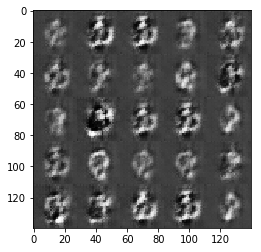

Epoch 2/3..., step 1010 Discriminator Loss: 0.3575... Generator Loss: 2.3246
Epoch 2/3..., step 1020 Discriminator Loss: 0.3050... Generator Loss: 3.2132
Epoch 2/3..., step 1030 Discriminator Loss: 0.3967... Generator Loss: 3.2865
Epoch 2/3..., step 1040 Discriminator Loss: 0.4650... Generator Loss: 3.3436
Epoch 2/3..., step 1050 Discriminator Loss: 0.4431... Generator Loss: 2.5574
Epoch 2/3..., step 1060 Discriminator Loss: 0.3587... Generator Loss: 2.9180
Epoch 2/3..., step 1070 Discriminator Loss: 0.3566... Generator Loss: 2.7132
Epoch 2/3..., step 1080 Discriminator Loss: 0.4607... Generator Loss: 2.1607
Epoch 2/3..., step 1090 Discriminator Loss: 0.5820... Generator Loss: 4.4871
Epoch 2/3..., step 1100 Discriminator Loss: 0.4526... Generator Loss: 2.3369
Epoch 2/3..., step 1110 Discriminator Loss: 0.7646... Generator Loss: 1.3031
Epoch 2/3..., step 1120 Discriminator Loss: 0.3912... Generator Loss: 2.2995
Epoch 2/3..., step 1130 Discriminator Loss: 0.3685... Generator Loss: 2.6743

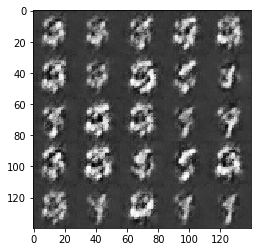

Epoch 2/3..., step 1210 Discriminator Loss: 0.4708... Generator Loss: 2.3444
Epoch 2/3..., step 1220 Discriminator Loss: 0.4374... Generator Loss: 2.8388
Epoch 2/3..., step 1230 Discriminator Loss: 0.4257... Generator Loss: 3.1707
Epoch 2/3..., step 1240 Discriminator Loss: 0.4616... Generator Loss: 2.7577
Epoch 2/3..., step 1250 Discriminator Loss: 0.3396... Generator Loss: 2.6449
Epoch 2/3..., step 1260 Discriminator Loss: 0.2757... Generator Loss: 3.0304
Epoch 2/3..., step 1270 Discriminator Loss: 0.4814... Generator Loss: 2.6011
Epoch 2/3..., step 1280 Discriminator Loss: 0.4543... Generator Loss: 2.4412
Epoch 2/3..., step 1290 Discriminator Loss: 0.4543... Generator Loss: 2.8914
Epoch 2/3..., step 1300 Discriminator Loss: 0.4371... Generator Loss: 2.1825
Epoch 2/3..., step 1310 Discriminator Loss: 0.4521... Generator Loss: 1.7475
Epoch 2/3..., step 1320 Discriminator Loss: 0.4279... Generator Loss: 3.0979
Epoch 2/3..., step 1330 Discriminator Loss: 0.4512... Generator Loss: 3.8432

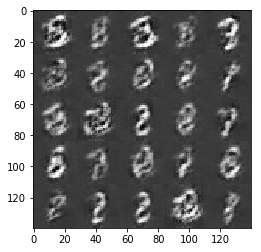

Epoch 2/3..., step 1410 Discriminator Loss: 0.5407... Generator Loss: 2.3689
Epoch 2/3..., step 1420 Discriminator Loss: 0.2952... Generator Loss: 3.0670
Epoch 2/3..., step 1430 Discriminator Loss: 0.6677... Generator Loss: 2.4228
Epoch 2/3..., step 1440 Discriminator Loss: 0.4045... Generator Loss: 2.9868
Epoch 2/3..., step 1450 Discriminator Loss: 0.4153... Generator Loss: 2.4826
Epoch 2/3..., step 1460 Discriminator Loss: 0.4452... Generator Loss: 2.5776
Epoch 2/3..., step 1470 Discriminator Loss: 0.4322... Generator Loss: 2.8690
Epoch 2/3..., step 1480 Discriminator Loss: 0.3699... Generator Loss: 2.6602
Epoch 2/3..., step 1490 Discriminator Loss: 0.3788... Generator Loss: 2.8147
Epoch 2/3..., step 1500 Discriminator Loss: 0.4079... Generator Loss: 3.4012
Epoch 2/3..., step 1510 Discriminator Loss: 0.4342... Generator Loss: 2.4467
Epoch 2/3..., step 1520 Discriminator Loss: 0.5080... Generator Loss: 1.8885
Epoch 2/3..., step 1530 Discriminator Loss: 0.4080... Generator Loss: 2.7404

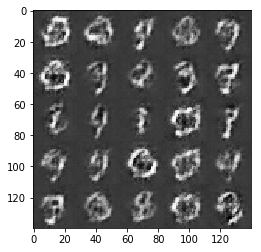

Epoch 2/3..., step 1610 Discriminator Loss: 0.4624... Generator Loss: 2.0629
Epoch 2/3..., step 1620 Discriminator Loss: 0.3913... Generator Loss: 2.6579
Epoch 2/3..., step 1630 Discriminator Loss: 0.3598... Generator Loss: 3.1889
Epoch 2/3..., step 1640 Discriminator Loss: 0.4145... Generator Loss: 3.2741
Epoch 2/3..., step 1650 Discriminator Loss: 0.4324... Generator Loss: 3.3698
Epoch 2/3..., step 1660 Discriminator Loss: 0.4390... Generator Loss: 1.8612
Epoch 2/3..., step 1670 Discriminator Loss: 0.4577... Generator Loss: 2.7285
Epoch 2/3..., step 1680 Discriminator Loss: 0.3337... Generator Loss: 3.3973
Epoch 2/3..., step 1690 Discriminator Loss: 0.3579... Generator Loss: 2.7228
Epoch 2/3..., step 1700 Discriminator Loss: 0.4597... Generator Loss: 1.9761
Epoch 2/3..., step 1710 Discriminator Loss: 0.4557... Generator Loss: 2.7214
Epoch 2/3..., step 1720 Discriminator Loss: 0.4628... Generator Loss: 2.6964
Epoch 2/3..., step 1730 Discriminator Loss: 0.3850... Generator Loss: 2.8108

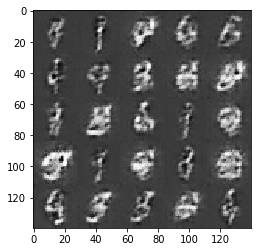

Epoch 2/3..., step 1810 Discriminator Loss: 0.4139... Generator Loss: 2.1615
Epoch 2/3..., step 1820 Discriminator Loss: 0.4207... Generator Loss: 2.0218
Epoch 2/3..., step 1830 Discriminator Loss: 0.4233... Generator Loss: 3.2865
Epoch 2/3..., step 1840 Discriminator Loss: 0.4701... Generator Loss: 2.3768
Epoch 2/3..., step 1850 Discriminator Loss: 0.3212... Generator Loss: 3.0706
Epoch 2/3..., step 1860 Discriminator Loss: 0.5784... Generator Loss: 1.4348
Epoch 2/3..., step 1870 Discriminator Loss: 0.4112... Generator Loss: 2.0954
Epoch 3/3..., step 1880 Discriminator Loss: 0.5006... Generator Loss: 1.8264
Epoch 3/3..., step 1890 Discriminator Loss: 0.4594... Generator Loss: 2.4701
Epoch 3/3..., step 1900 Discriminator Loss: 0.4034... Generator Loss: 3.4770
Epoch 3/3..., step 1910 Discriminator Loss: 0.4450... Generator Loss: 2.0340
Epoch 3/3..., step 1920 Discriminator Loss: 0.4677... Generator Loss: 2.9486
Epoch 3/3..., step 1930 Discriminator Loss: 0.4390... Generator Loss: 2.6228

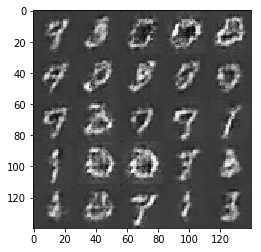

Epoch 3/3..., step 2010 Discriminator Loss: 0.4531... Generator Loss: 2.6911
Epoch 3/3..., step 2020 Discriminator Loss: 0.4882... Generator Loss: 2.7803
Epoch 3/3..., step 2030 Discriminator Loss: 0.5398... Generator Loss: 1.9633
Epoch 3/3..., step 2040 Discriminator Loss: 0.4678... Generator Loss: 3.5378
Epoch 3/3..., step 2050 Discriminator Loss: 0.7181... Generator Loss: 3.7726
Epoch 3/3..., step 2060 Discriminator Loss: 0.5572... Generator Loss: 3.8437
Epoch 3/3..., step 2070 Discriminator Loss: 0.4133... Generator Loss: 2.1961
Epoch 3/3..., step 2080 Discriminator Loss: 0.5410... Generator Loss: 1.7677
Epoch 3/3..., step 2090 Discriminator Loss: 0.4115... Generator Loss: 2.5540
Epoch 3/3..., step 2100 Discriminator Loss: 0.5158... Generator Loss: 2.0094
Epoch 3/3..., step 2110 Discriminator Loss: 0.4706... Generator Loss: 2.6402
Epoch 3/3..., step 2120 Discriminator Loss: 0.5301... Generator Loss: 1.8363
Epoch 3/3..., step 2130 Discriminator Loss: 0.4348... Generator Loss: 2.1724

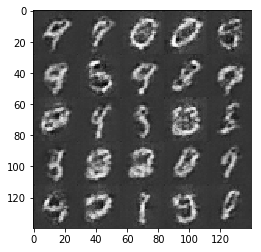

Epoch 3/3..., step 2210 Discriminator Loss: 0.4892... Generator Loss: 2.3435
Epoch 3/3..., step 2220 Discriminator Loss: 0.5886... Generator Loss: 3.1545
Epoch 3/3..., step 2230 Discriminator Loss: 0.6697... Generator Loss: 1.2293
Epoch 3/3..., step 2240 Discriminator Loss: 0.8019... Generator Loss: 1.1528
Epoch 3/3..., step 2250 Discriminator Loss: 0.5081... Generator Loss: 1.5687
Epoch 3/3..., step 2260 Discriminator Loss: 0.5102... Generator Loss: 4.2855
Epoch 3/3..., step 2270 Discriminator Loss: 0.4148... Generator Loss: 2.2998
Epoch 3/3..., step 2280 Discriminator Loss: 0.4433... Generator Loss: 2.0285
Epoch 3/3..., step 2290 Discriminator Loss: 0.4808... Generator Loss: 2.2182
Epoch 3/3..., step 2300 Discriminator Loss: 0.4331... Generator Loss: 2.3783
Epoch 3/3..., step 2310 Discriminator Loss: 0.4804... Generator Loss: 2.3783
Epoch 3/3..., step 2320 Discriminator Loss: 0.4919... Generator Loss: 2.1289
Epoch 3/3..., step 2330 Discriminator Loss: 0.4188... Generator Loss: 2.8930

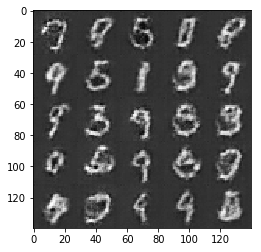

Epoch 3/3..., step 2410 Discriminator Loss: 0.3995... Generator Loss: 3.2548
Epoch 3/3..., step 2420 Discriminator Loss: 0.6099... Generator Loss: 1.4560
Epoch 3/3..., step 2430 Discriminator Loss: 0.4503... Generator Loss: 2.8058
Epoch 3/3..., step 2440 Discriminator Loss: 0.7987... Generator Loss: 1.1808
Epoch 3/3..., step 2450 Discriminator Loss: 0.3814... Generator Loss: 2.5305
Epoch 3/3..., step 2460 Discriminator Loss: 0.5420... Generator Loss: 2.1555
Epoch 3/3..., step 2470 Discriminator Loss: 0.5016... Generator Loss: 2.4897
Epoch 3/3..., step 2480 Discriminator Loss: 0.5178... Generator Loss: 1.9157
Epoch 3/3..., step 2490 Discriminator Loss: 1.2349... Generator Loss: 0.6225
Epoch 3/3..., step 2500 Discriminator Loss: 0.8890... Generator Loss: 1.0486
Epoch 3/3..., step 2510 Discriminator Loss: 0.5026... Generator Loss: 2.5534
Epoch 3/3..., step 2520 Discriminator Loss: 0.5066... Generator Loss: 2.0463
Epoch 3/3..., step 2530 Discriminator Loss: 0.4584... Generator Loss: 2.2214

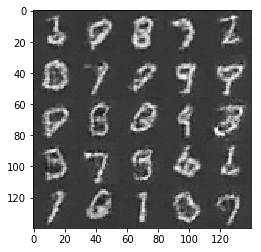

Epoch 3/3..., step 2610 Discriminator Loss: 0.4882... Generator Loss: 2.2435
Epoch 3/3..., step 2620 Discriminator Loss: 0.4525... Generator Loss: 2.9101
Epoch 3/3..., step 2630 Discriminator Loss: 0.3941... Generator Loss: 2.6863
Epoch 3/3..., step 2640 Discriminator Loss: 0.4309... Generator Loss: 2.3085
Epoch 3/3..., step 2650 Discriminator Loss: 0.4497... Generator Loss: 2.4519
Epoch 3/3..., step 2660 Discriminator Loss: 0.6199... Generator Loss: 1.3039
Epoch 3/3..., step 2670 Discriminator Loss: 0.4830... Generator Loss: 2.4860
Epoch 3/3..., step 2680 Discriminator Loss: 0.4129... Generator Loss: 2.7973
Epoch 3/3..., step 2690 Discriminator Loss: 0.5966... Generator Loss: 1.6706
Epoch 3/3..., step 2700 Discriminator Loss: 0.5812... Generator Loss: 3.7037
Epoch 3/3..., step 2710 Discriminator Loss: 0.5419... Generator Loss: 4.7275
Epoch 3/3..., step 2720 Discriminator Loss: 0.4174... Generator Loss: 2.1896
Epoch 3/3..., step 2730 Discriminator Loss: 0.4821... Generator Loss: 2.5782

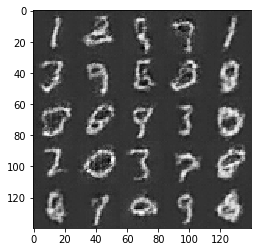

Epoch 3/3..., step 2810 Discriminator Loss: 0.4147... Generator Loss: 2.8692


In [38]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2..., step 10 Discriminator Loss: 1.5077... Generator Loss: 5.7631
Epoch 1/2..., step 20 Discriminator Loss: 2.2131... Generator Loss: 0.3270
Epoch 1/2..., step 30 Discriminator Loss: 0.3713... Generator Loss: 2.1994
Epoch 1/2..., step 40 Discriminator Loss: 0.5154... Generator Loss: 5.5918
Epoch 1/2..., step 50 Discriminator Loss: 0.9347... Generator Loss: 2.3606
Epoch 1/2..., step 60 Discriminator Loss: 0.2603... Generator Loss: 5.6613
Epoch 1/2..., step 70 Discriminator Loss: 0.3581... Generator Loss: 6.6189
Epoch 1/2..., step 80 Discriminator Loss: 2.2603... Generator Loss: 0.4703
Epoch 1/2..., step 90 Discriminator Loss: 0.2542... Generator Loss: 3.4851
Epoch 1/2..., step 100 Discriminator Loss: 0.5953... Generator Loss: 1.8016
Epoch 1/2..., step 110 Discriminator Loss: 0.2173... Generator Loss: 5.6687
Epoch 1/2..., step 120 Discriminator Loss: 0.3476... Generator Loss: 3.9104
Epoch 1/2..., step 130 Discriminator Loss: 0.1775... Generator Loss: 7.7151
Epoch 1/2..., step 14

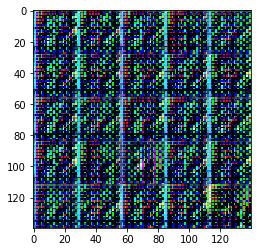

Epoch 1/2..., step 210 Discriminator Loss: 0.2720... Generator Loss: 5.5477
Epoch 1/2..., step 220 Discriminator Loss: 0.2675... Generator Loss: 4.6054
Epoch 1/2..., step 230 Discriminator Loss: 0.2929... Generator Loss: 6.1513
Epoch 1/2..., step 240 Discriminator Loss: 0.3371... Generator Loss: 5.7925
Epoch 1/2..., step 250 Discriminator Loss: 0.2493... Generator Loss: 7.5005
Epoch 1/2..., step 260 Discriminator Loss: 0.3391... Generator Loss: 5.1331
Epoch 1/2..., step 270 Discriminator Loss: 0.3377... Generator Loss: 6.0112
Epoch 1/2..., step 280 Discriminator Loss: 0.3104... Generator Loss: 4.4818
Epoch 1/2..., step 290 Discriminator Loss: 0.3297... Generator Loss: 4.5404
Epoch 1/2..., step 300 Discriminator Loss: 0.2710... Generator Loss: 7.4427
Epoch 1/2..., step 310 Discriminator Loss: 0.3039... Generator Loss: 6.0620
Epoch 1/2..., step 320 Discriminator Loss: 0.2928... Generator Loss: 6.8681
Epoch 1/2..., step 330 Discriminator Loss: 0.2509... Generator Loss: 4.7103
Epoch 1/2...

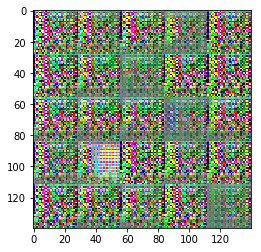

Epoch 1/2..., step 410 Discriminator Loss: 0.2710... Generator Loss: 7.4374
Epoch 1/2..., step 420 Discriminator Loss: 0.5392... Generator Loss: 1.2745
Epoch 1/2..., step 430 Discriminator Loss: 0.4062... Generator Loss: 5.6803
Epoch 1/2..., step 440 Discriminator Loss: 1.0922... Generator Loss: 21.1511
Epoch 1/2..., step 450 Discriminator Loss: 0.2394... Generator Loss: 8.3746
Epoch 1/2..., step 460 Discriminator Loss: 11.2608... Generator Loss: 32.4682
Epoch 1/2..., step 470 Discriminator Loss: 0.3093... Generator Loss: 8.9607
Epoch 1/2..., step 480 Discriminator Loss: 0.4139... Generator Loss: 4.4742
Epoch 1/2..., step 490 Discriminator Loss: 0.2641... Generator Loss: 5.5592
Epoch 1/2..., step 500 Discriminator Loss: 0.2732... Generator Loss: 4.5937
Epoch 1/2..., step 510 Discriminator Loss: 1.2882... Generator Loss: 1.1495
Epoch 1/2..., step 520 Discriminator Loss: 0.2286... Generator Loss: 6.7858
Epoch 1/2..., step 530 Discriminator Loss: 0.2059... Generator Loss: 8.3383
Epoch 1/2

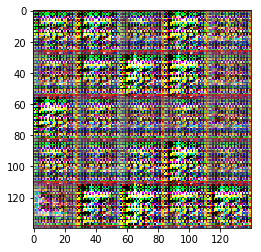

Epoch 1/2..., step 610 Discriminator Loss: 0.2392... Generator Loss: 13.6356
Epoch 1/2..., step 620 Discriminator Loss: 0.2925... Generator Loss: 8.1392
Epoch 1/2..., step 630 Discriminator Loss: 0.3367... Generator Loss: 15.4160
Epoch 1/2..., step 640 Discriminator Loss: 0.7667... Generator Loss: 0.8579
Epoch 1/2..., step 650 Discriminator Loss: 0.1632... Generator Loss: 7.1566
Epoch 1/2..., step 660 Discriminator Loss: 0.7023... Generator Loss: 2.0590
Epoch 1/2..., step 670 Discriminator Loss: 0.2725... Generator Loss: 7.8992
Epoch 1/2..., step 680 Discriminator Loss: 0.3875... Generator Loss: 2.4383
Epoch 1/2..., step 690 Discriminator Loss: 0.4643... Generator Loss: 4.6033
Epoch 1/2..., step 700 Discriminator Loss: 0.4031... Generator Loss: 5.8247
Epoch 1/2..., step 710 Discriminator Loss: 0.2543... Generator Loss: 5.7437
Epoch 1/2..., step 720 Discriminator Loss: 0.2337... Generator Loss: 5.0263
Epoch 1/2..., step 730 Discriminator Loss: 0.2511... Generator Loss: 6.9350
Epoch 1/2.

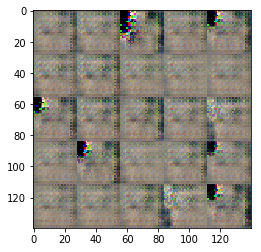

Epoch 1/2..., step 810 Discriminator Loss: 2.5123... Generator Loss: 0.2672
Epoch 1/2..., step 820 Discriminator Loss: 0.3649... Generator Loss: 3.6123
Epoch 1/2..., step 830 Discriminator Loss: 2.4756... Generator Loss: 0.3944
Epoch 1/2..., step 840 Discriminator Loss: 0.8762... Generator Loss: 1.5088
Epoch 1/2..., step 850 Discriminator Loss: 0.2641... Generator Loss: 3.8898
Epoch 1/2..., step 860 Discriminator Loss: 0.3766... Generator Loss: 3.2246
Epoch 1/2..., step 870 Discriminator Loss: 0.3453... Generator Loss: 3.8750
Epoch 1/2..., step 880 Discriminator Loss: 0.2157... Generator Loss: 4.5148
Epoch 1/2..., step 890 Discriminator Loss: 0.2541... Generator Loss: 6.7555
Epoch 1/2..., step 900 Discriminator Loss: 0.3596... Generator Loss: 5.3397
Epoch 1/2..., step 910 Discriminator Loss: 0.3053... Generator Loss: 9.5663
Epoch 1/2..., step 920 Discriminator Loss: 0.2426... Generator Loss: 6.7861
Epoch 1/2..., step 930 Discriminator Loss: 0.4179... Generator Loss: 2.2087
Epoch 1/2...

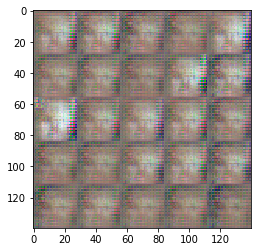

Epoch 1/2..., step 1010 Discriminator Loss: 0.2762... Generator Loss: 6.6803
Epoch 1/2..., step 1020 Discriminator Loss: 3.9720... Generator Loss: 0.1957
Epoch 1/2..., step 1030 Discriminator Loss: 0.7389... Generator Loss: 2.2708
Epoch 1/2..., step 1040 Discriminator Loss: 0.9241... Generator Loss: 1.2817
Epoch 1/2..., step 1050 Discriminator Loss: 0.6620... Generator Loss: 2.6768
Epoch 1/2..., step 1060 Discriminator Loss: 1.2780... Generator Loss: 4.3197
Epoch 1/2..., step 1070 Discriminator Loss: 0.9636... Generator Loss: 0.9861
Epoch 1/2..., step 1080 Discriminator Loss: 0.9922... Generator Loss: 0.8117
Epoch 1/2..., step 1090 Discriminator Loss: 0.5686... Generator Loss: 1.2343
Epoch 1/2..., step 1100 Discriminator Loss: 1.2320... Generator Loss: 0.5965
Epoch 1/2..., step 1110 Discriminator Loss: 2.5365... Generator Loss: 3.2697
Epoch 1/2..., step 1120 Discriminator Loss: 1.2257... Generator Loss: 0.5880
Epoch 1/2..., step 1130 Discriminator Loss: 1.5026... Generator Loss: 0.5579

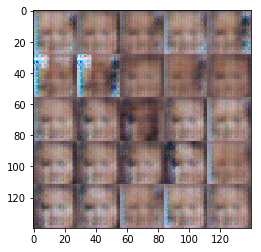

Epoch 1/2..., step 1210 Discriminator Loss: 1.5748... Generator Loss: 0.4937
Epoch 1/2..., step 1220 Discriminator Loss: 1.2466... Generator Loss: 2.5544
Epoch 1/2..., step 1230 Discriminator Loss: 0.8120... Generator Loss: 1.1388
Epoch 1/2..., step 1240 Discriminator Loss: 0.9434... Generator Loss: 1.9183
Epoch 1/2..., step 1250 Discriminator Loss: 1.2383... Generator Loss: 1.3459
Epoch 1/2..., step 1260 Discriminator Loss: 2.7016... Generator Loss: 4.7868
Epoch 1/2..., step 1270 Discriminator Loss: 0.6078... Generator Loss: 2.6092
Epoch 1/2..., step 1280 Discriminator Loss: 1.1281... Generator Loss: 0.8352
Epoch 1/2..., step 1290 Discriminator Loss: 0.8054... Generator Loss: 1.1567
Epoch 1/2..., step 1300 Discriminator Loss: 0.5687... Generator Loss: 3.4585
Epoch 1/2..., step 1310 Discriminator Loss: 1.8053... Generator Loss: 2.2871
Epoch 1/2..., step 1320 Discriminator Loss: 0.6905... Generator Loss: 1.4076
Epoch 1/2..., step 1330 Discriminator Loss: 1.7407... Generator Loss: 1.7648

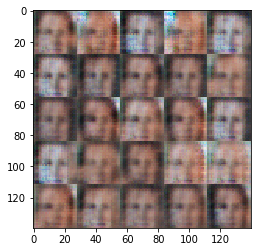

Epoch 1/2..., step 1410 Discriminator Loss: 1.3076... Generator Loss: 0.5768
Epoch 1/2..., step 1420 Discriminator Loss: 3.5633... Generator Loss: 0.2281
Epoch 1/2..., step 1430 Discriminator Loss: 0.4968... Generator Loss: 2.9878
Epoch 1/2..., step 1440 Discriminator Loss: 0.4461... Generator Loss: 2.5045
Epoch 1/2..., step 1450 Discriminator Loss: 5.3600... Generator Loss: 4.4920
Epoch 1/2..., step 1460 Discriminator Loss: 1.4183... Generator Loss: 0.6858
Epoch 1/2..., step 1470 Discriminator Loss: 1.1788... Generator Loss: 0.8791
Epoch 1/2..., step 1480 Discriminator Loss: 0.7560... Generator Loss: 1.2683
Epoch 1/2..., step 1490 Discriminator Loss: 0.5804... Generator Loss: 1.2937
Epoch 1/2..., step 1500 Discriminator Loss: 0.5265... Generator Loss: 1.7115
Epoch 1/2..., step 1510 Discriminator Loss: 0.8103... Generator Loss: 1.0570
Epoch 1/2..., step 1520 Discriminator Loss: 1.7512... Generator Loss: 1.6405
Epoch 1/2..., step 1530 Discriminator Loss: 1.0724... Generator Loss: 0.7875

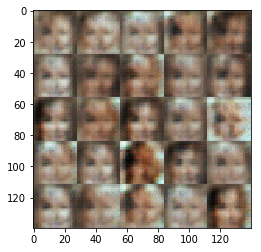

Epoch 1/2..., step 1610 Discriminator Loss: 0.4295... Generator Loss: 1.9597
Epoch 1/2..., step 1620 Discriminator Loss: 1.4993... Generator Loss: 0.6204
Epoch 1/2..., step 1630 Discriminator Loss: 1.0581... Generator Loss: 3.4150
Epoch 1/2..., step 1640 Discriminator Loss: 0.5326... Generator Loss: 2.0648
Epoch 1/2..., step 1650 Discriminator Loss: 0.3706... Generator Loss: 2.2208
Epoch 1/2..., step 1660 Discriminator Loss: 1.5680... Generator Loss: 0.3951
Epoch 1/2..., step 1670 Discriminator Loss: 1.1135... Generator Loss: 1.3049
Epoch 1/2..., step 1680 Discriminator Loss: 1.0154... Generator Loss: 0.8408
Epoch 1/2..., step 1690 Discriminator Loss: 0.5575... Generator Loss: 1.5227
Epoch 1/2..., step 1700 Discriminator Loss: 1.1480... Generator Loss: 0.6180
Epoch 1/2..., step 1710 Discriminator Loss: 1.0196... Generator Loss: 2.0336
Epoch 1/2..., step 1720 Discriminator Loss: 2.1206... Generator Loss: 5.9474
Epoch 1/2..., step 1730 Discriminator Loss: 0.3797... Generator Loss: 3.9790

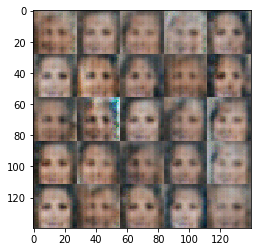

Epoch 1/2..., step 1810 Discriminator Loss: 0.7493... Generator Loss: 1.3015
Epoch 1/2..., step 1820 Discriminator Loss: 0.9865... Generator Loss: 0.7322
Epoch 1/2..., step 1830 Discriminator Loss: 0.3059... Generator Loss: 3.9799
Epoch 1/2..., step 1840 Discriminator Loss: 0.2699... Generator Loss: 3.0562
Epoch 1/2..., step 1850 Discriminator Loss: 0.2793... Generator Loss: 4.2737
Epoch 1/2..., step 1860 Discriminator Loss: 0.8285... Generator Loss: 1.7132
Epoch 1/2..., step 1870 Discriminator Loss: 0.3283... Generator Loss: 3.2361
Epoch 1/2..., step 1880 Discriminator Loss: 0.2724... Generator Loss: 3.4002
Epoch 1/2..., step 1890 Discriminator Loss: 1.4754... Generator Loss: 0.4968
Epoch 1/2..., step 1900 Discriminator Loss: 0.3586... Generator Loss: 3.9087
Epoch 1/2..., step 1910 Discriminator Loss: 0.3072... Generator Loss: 3.7091
Epoch 1/2..., step 1920 Discriminator Loss: 0.2635... Generator Loss: 8.9077
Epoch 1/2..., step 1930 Discriminator Loss: 0.3319... Generator Loss: 2.5165

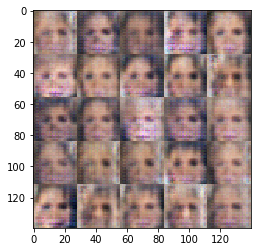

Epoch 1/2..., step 2010 Discriminator Loss: 0.3633... Generator Loss: 3.9387
Epoch 1/2..., step 2020 Discriminator Loss: 0.2790... Generator Loss: 3.1015
Epoch 1/2..., step 2030 Discriminator Loss: 3.3063... Generator Loss: 3.2864
Epoch 1/2..., step 2040 Discriminator Loss: 1.3422... Generator Loss: 1.0824
Epoch 1/2..., step 2050 Discriminator Loss: 1.1886... Generator Loss: 0.9353
Epoch 1/2..., step 2060 Discriminator Loss: 1.0042... Generator Loss: 0.7761
Epoch 1/2..., step 2070 Discriminator Loss: 0.5215... Generator Loss: 1.4989
Epoch 1/2..., step 2080 Discriminator Loss: 0.4909... Generator Loss: 5.2983
Epoch 1/2..., step 2090 Discriminator Loss: 1.5344... Generator Loss: 0.3948
Epoch 1/2..., step 2100 Discriminator Loss: 0.7782... Generator Loss: 1.4682
Epoch 1/2..., step 2110 Discriminator Loss: 0.2952... Generator Loss: 2.4903
Epoch 1/2..., step 2120 Discriminator Loss: 2.9105... Generator Loss: 3.8741
Epoch 1/2..., step 2130 Discriminator Loss: 0.6350... Generator Loss: 2.3564

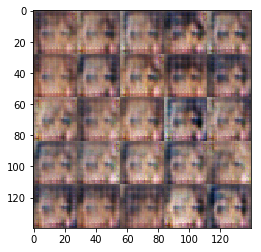

Epoch 1/2..., step 2210 Discriminator Loss: 0.2899... Generator Loss: 4.0079
Epoch 1/2..., step 2220 Discriminator Loss: 0.5548... Generator Loss: 6.6678
Epoch 1/2..., step 2230 Discriminator Loss: 0.3870... Generator Loss: 2.3546
Epoch 1/2..., step 2240 Discriminator Loss: 0.3064... Generator Loss: 7.0073
Epoch 1/2..., step 2250 Discriminator Loss: 0.2408... Generator Loss: 6.4111
Epoch 1/2..., step 2260 Discriminator Loss: 0.1670... Generator Loss: 4.7413
Epoch 1/2..., step 2270 Discriminator Loss: 0.2870... Generator Loss: 6.7493
Epoch 1/2..., step 2280 Discriminator Loss: 0.2851... Generator Loss: 5.2580
Epoch 1/2..., step 2290 Discriminator Loss: 0.2706... Generator Loss: 4.0405
Epoch 1/2..., step 2300 Discriminator Loss: 0.4168... Generator Loss: 1.8682
Epoch 1/2..., step 2310 Discriminator Loss: 0.8799... Generator Loss: 1.1410
Epoch 1/2..., step 2320 Discriminator Loss: 1.4429... Generator Loss: 0.6595
Epoch 1/2..., step 2330 Discriminator Loss: 0.5114... Generator Loss: 1.5116

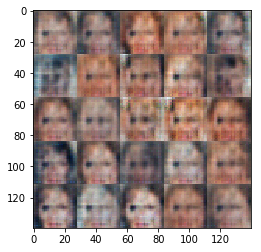

Epoch 1/2..., step 2410 Discriminator Loss: 0.3558... Generator Loss: 1.7735
Epoch 1/2..., step 2420 Discriminator Loss: 0.4990... Generator Loss: 1.5602
Epoch 1/2..., step 2430 Discriminator Loss: 0.7337... Generator Loss: 1.6307
Epoch 1/2..., step 2440 Discriminator Loss: 0.9293... Generator Loss: 0.9032
Epoch 1/2..., step 2450 Discriminator Loss: 0.3467... Generator Loss: 3.8470
Epoch 1/2..., step 2460 Discriminator Loss: 1.6105... Generator Loss: 0.6559
Epoch 1/2..., step 2470 Discriminator Loss: 1.3765... Generator Loss: 0.5743
Epoch 1/2..., step 2480 Discriminator Loss: 1.1493... Generator Loss: 1.5234
Epoch 1/2..., step 2490 Discriminator Loss: 0.8528... Generator Loss: 1.2679
Epoch 1/2..., step 2500 Discriminator Loss: 0.8002... Generator Loss: 1.4950
Epoch 1/2..., step 2510 Discriminator Loss: 0.4876... Generator Loss: 3.8605
Epoch 1/2..., step 2520 Discriminator Loss: 0.5414... Generator Loss: 1.3823
Epoch 1/2..., step 2530 Discriminator Loss: 0.3201... Generator Loss: 5.4654

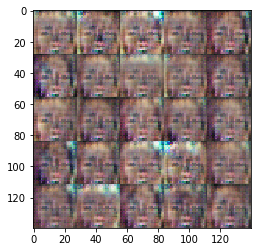

Epoch 1/2..., step 2610 Discriminator Loss: 6.0904... Generator Loss: 4.9534
Epoch 1/2..., step 2620 Discriminator Loss: 0.8072... Generator Loss: 1.2352
Epoch 1/2..., step 2630 Discriminator Loss: 1.4403... Generator Loss: 0.6515
Epoch 1/2..., step 2640 Discriminator Loss: 1.0412... Generator Loss: 2.0779
Epoch 1/2..., step 2650 Discriminator Loss: 1.0662... Generator Loss: 1.1198
Epoch 1/2..., step 2660 Discriminator Loss: 0.8644... Generator Loss: 4.2976
Epoch 1/2..., step 2670 Discriminator Loss: 1.1146... Generator Loss: 1.7045
Epoch 1/2..., step 2680 Discriminator Loss: 1.5119... Generator Loss: 0.8077
Epoch 1/2..., step 2690 Discriminator Loss: 0.8075... Generator Loss: 1.6006
Epoch 1/2..., step 2700 Discriminator Loss: 0.6510... Generator Loss: 1.6876
Epoch 1/2..., step 2710 Discriminator Loss: 0.5199... Generator Loss: 1.7983
Epoch 1/2..., step 2720 Discriminator Loss: 1.0066... Generator Loss: 2.1911
Epoch 1/2..., step 2730 Discriminator Loss: 0.6505... Generator Loss: 1.7692

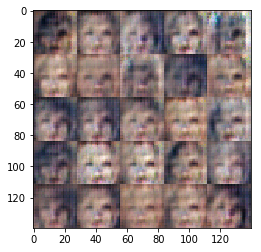

Epoch 1/2..., step 2810 Discriminator Loss: 0.2693... Generator Loss: 7.3259
Epoch 1/2..., step 2820 Discriminator Loss: 0.3420... Generator Loss: 4.9804
Epoch 1/2..., step 2830 Discriminator Loss: 0.3053... Generator Loss: 5.6109
Epoch 1/2..., step 2840 Discriminator Loss: 0.2740... Generator Loss: 5.5607
Epoch 1/2..., step 2850 Discriminator Loss: 0.3281... Generator Loss: 3.2498
Epoch 1/2..., step 2860 Discriminator Loss: 0.3655... Generator Loss: 4.8210
Epoch 1/2..., step 2870 Discriminator Loss: 0.3444... Generator Loss: 1.8623
Epoch 1/2..., step 2880 Discriminator Loss: 5.9389... Generator Loss: 7.1749
Epoch 1/2..., step 2890 Discriminator Loss: 2.6298... Generator Loss: 4.8565
Epoch 1/2..., step 2900 Discriminator Loss: 0.6286... Generator Loss: 1.7717
Epoch 1/2..., step 2910 Discriminator Loss: 1.5444... Generator Loss: 0.8223
Epoch 1/2..., step 2920 Discriminator Loss: 1.0283... Generator Loss: 0.9959
Epoch 1/2..., step 2930 Discriminator Loss: 0.9746... Generator Loss: 1.1042

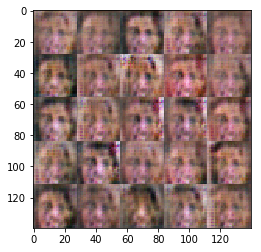

Epoch 1/2..., step 3010 Discriminator Loss: 0.3065... Generator Loss: 2.5371
Epoch 1/2..., step 3020 Discriminator Loss: 1.0731... Generator Loss: 2.1316
Epoch 1/2..., step 3030 Discriminator Loss: 1.3322... Generator Loss: 1.2140
Epoch 1/2..., step 3040 Discriminator Loss: 1.1236... Generator Loss: 0.9045
Epoch 1/2..., step 3050 Discriminator Loss: 1.1327... Generator Loss: 1.1184
Epoch 1/2..., step 3060 Discriminator Loss: 1.3403... Generator Loss: 0.6459
Epoch 1/2..., step 3070 Discriminator Loss: 1.3278... Generator Loss: 0.7685
Epoch 1/2..., step 3080 Discriminator Loss: 0.9485... Generator Loss: 1.0285
Epoch 1/2..., step 3090 Discriminator Loss: 0.8015... Generator Loss: 0.8731
Epoch 1/2..., step 3100 Discriminator Loss: 0.3690... Generator Loss: 3.7452
Epoch 1/2..., step 3110 Discriminator Loss: 0.2947... Generator Loss: 3.9652
Epoch 1/2..., step 3120 Discriminator Loss: 0.2606... Generator Loss: 4.7806
Epoch 1/2..., step 3130 Discriminator Loss: 0.2447... Generator Loss: 3.6123

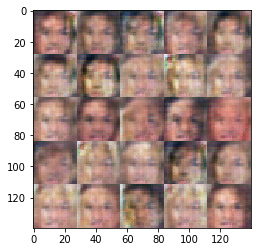

Epoch 2/2..., step 3210 Discriminator Loss: 1.3063... Generator Loss: 0.7952
Epoch 2/2..., step 3220 Discriminator Loss: 0.7648... Generator Loss: 1.3056
Epoch 2/2..., step 3230 Discriminator Loss: 1.6065... Generator Loss: 0.4885
Epoch 2/2..., step 3240 Discriminator Loss: 1.1679... Generator Loss: 0.7044
Epoch 2/2..., step 3250 Discriminator Loss: 0.4144... Generator Loss: 2.4292
Epoch 2/2..., step 3260 Discriminator Loss: 1.0646... Generator Loss: 0.7941
Epoch 2/2..., step 3270 Discriminator Loss: 0.3977... Generator Loss: 2.4970
Epoch 2/2..., step 3280 Discriminator Loss: 0.3060... Generator Loss: 2.0631
Epoch 2/2..., step 3290 Discriminator Loss: 0.3614... Generator Loss: 2.5156
Epoch 2/2..., step 3300 Discriminator Loss: 0.5987... Generator Loss: 0.9392
Epoch 2/2..., step 3310 Discriminator Loss: 0.6826... Generator Loss: 2.7765
Epoch 2/2..., step 3320 Discriminator Loss: 0.6493... Generator Loss: 1.1804
Epoch 2/2..., step 3330 Discriminator Loss: 1.9641... Generator Loss: 4.0016

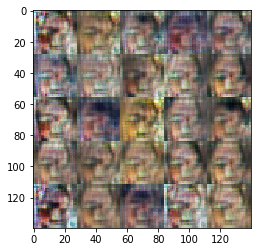

Epoch 2/2..., step 3410 Discriminator Loss: 0.3455... Generator Loss: 5.1932
Epoch 2/2..., step 3420 Discriminator Loss: 0.2992... Generator Loss: 2.5045
Epoch 2/2..., step 3430 Discriminator Loss: 0.2890... Generator Loss: 8.4211
Epoch 2/2..., step 3440 Discriminator Loss: 0.2941... Generator Loss: 6.8450
Epoch 2/2..., step 3450 Discriminator Loss: 0.2394... Generator Loss: 6.5780
Epoch 2/2..., step 3460 Discriminator Loss: 0.3369... Generator Loss: 5.7710
Epoch 2/2..., step 3470 Discriminator Loss: 0.2513... Generator Loss: 5.1679
Epoch 2/2..., step 3480 Discriminator Loss: 0.2295... Generator Loss: 5.2714
Epoch 2/2..., step 3490 Discriminator Loss: 0.2523... Generator Loss: 4.3597
Epoch 2/2..., step 3500 Discriminator Loss: 0.2496... Generator Loss: 7.7867
Epoch 2/2..., step 3510 Discriminator Loss: 0.3045... Generator Loss: 5.8412
Epoch 2/2..., step 3520 Discriminator Loss: 0.2624... Generator Loss: 5.2588
Epoch 2/2..., step 3530 Discriminator Loss: 0.2623... Generator Loss: 5.4161

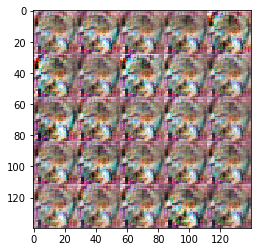

Epoch 2/2..., step 3610 Discriminator Loss: 0.3197... Generator Loss: 4.1395
Epoch 2/2..., step 3620 Discriminator Loss: 0.2427... Generator Loss: 4.6484
Epoch 2/2..., step 3630 Discriminator Loss: 0.3920... Generator Loss: 4.9521
Epoch 2/2..., step 3640 Discriminator Loss: 0.2419... Generator Loss: 3.2577
Epoch 2/2..., step 3650 Discriminator Loss: 0.2934... Generator Loss: 7.4544
Epoch 2/2..., step 3660 Discriminator Loss: 0.2613... Generator Loss: 8.5706
Epoch 2/2..., step 3670 Discriminator Loss: 1.9372... Generator Loss: 0.4241
Epoch 2/2..., step 3680 Discriminator Loss: 1.1078... Generator Loss: 1.1419
Epoch 2/2..., step 3690 Discriminator Loss: 0.9579... Generator Loss: 0.8450
Epoch 2/2..., step 3700 Discriminator Loss: 0.9684... Generator Loss: 1.1826
Epoch 2/2..., step 3710 Discriminator Loss: 1.0940... Generator Loss: 2.4008
Epoch 2/2..., step 3720 Discriminator Loss: 1.1486... Generator Loss: 0.7119
Epoch 2/2..., step 3730 Discriminator Loss: 1.5872... Generator Loss: 0.8607

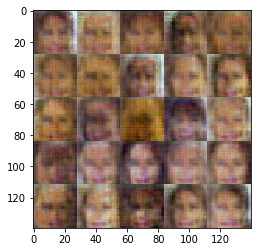

Epoch 2/2..., step 3810 Discriminator Loss: 1.7284... Generator Loss: 1.5411
Epoch 2/2..., step 3820 Discriminator Loss: 1.0332... Generator Loss: 1.1639
Epoch 2/2..., step 3830 Discriminator Loss: 1.2687... Generator Loss: 0.9027
Epoch 2/2..., step 3840 Discriminator Loss: 1.3348... Generator Loss: 0.8255
Epoch 2/2..., step 3850 Discriminator Loss: 1.3863... Generator Loss: 0.6319
Epoch 2/2..., step 3860 Discriminator Loss: 1.4278... Generator Loss: 0.8399
Epoch 2/2..., step 3870 Discriminator Loss: 1.2324... Generator Loss: 0.8454
Epoch 2/2..., step 3880 Discriminator Loss: 1.0271... Generator Loss: 1.1034
Epoch 2/2..., step 3890 Discriminator Loss: 1.3594... Generator Loss: 1.0083
Epoch 2/2..., step 3900 Discriminator Loss: 1.3145... Generator Loss: 0.6438
Epoch 2/2..., step 3910 Discriminator Loss: 1.1609... Generator Loss: 0.9826
Epoch 2/2..., step 3920 Discriminator Loss: 1.2939... Generator Loss: 0.8245
Epoch 2/2..., step 3930 Discriminator Loss: 1.2255... Generator Loss: 0.9518

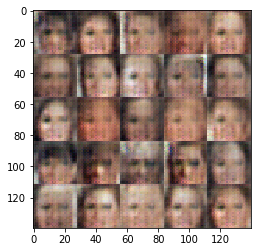

Epoch 2/2..., step 4010 Discriminator Loss: 1.3652... Generator Loss: 0.7566
Epoch 2/2..., step 4020 Discriminator Loss: 1.3701... Generator Loss: 0.6471
Epoch 2/2..., step 4030 Discriminator Loss: 1.3398... Generator Loss: 1.3985
Epoch 2/2..., step 4040 Discriminator Loss: 1.4413... Generator Loss: 1.0100
Epoch 2/2..., step 4050 Discriminator Loss: 1.1503... Generator Loss: 1.1476
Epoch 2/2..., step 4060 Discriminator Loss: 1.6737... Generator Loss: 0.3731
Epoch 2/2..., step 4070 Discriminator Loss: 1.0716... Generator Loss: 0.8806
Epoch 2/2..., step 4080 Discriminator Loss: 1.0302... Generator Loss: 0.9318
Epoch 2/2..., step 4090 Discriminator Loss: 1.0264... Generator Loss: 1.1864
Epoch 2/2..., step 4100 Discriminator Loss: 1.4261... Generator Loss: 0.5824
Epoch 2/2..., step 4110 Discriminator Loss: 1.4449... Generator Loss: 0.6577
Epoch 2/2..., step 4120 Discriminator Loss: 1.3223... Generator Loss: 0.7929
Epoch 2/2..., step 4130 Discriminator Loss: 1.3581... Generator Loss: 0.5038

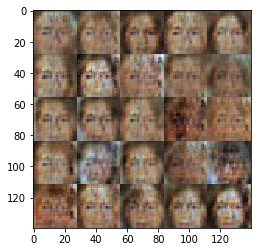

Epoch 2/2..., step 4210 Discriminator Loss: 1.2125... Generator Loss: 0.6939
Epoch 2/2..., step 4220 Discriminator Loss: 1.4573... Generator Loss: 1.1402
Epoch 2/2..., step 4230 Discriminator Loss: 0.9701... Generator Loss: 1.3506
Epoch 2/2..., step 4240 Discriminator Loss: 0.5809... Generator Loss: 2.0312
Epoch 2/2..., step 4250 Discriminator Loss: 1.6709... Generator Loss: 2.4157
Epoch 2/2..., step 4260 Discriminator Loss: 0.6265... Generator Loss: 1.9765
Epoch 2/2..., step 4270 Discriminator Loss: 0.8900... Generator Loss: 1.8056
Epoch 2/2..., step 4280 Discriminator Loss: 0.9377... Generator Loss: 2.4637
Epoch 2/2..., step 4290 Discriminator Loss: 0.9864... Generator Loss: 1.1850
Epoch 2/2..., step 4300 Discriminator Loss: 0.8074... Generator Loss: 2.8498
Epoch 2/2..., step 4310 Discriminator Loss: 0.5756... Generator Loss: 2.1984
Epoch 2/2..., step 4320 Discriminator Loss: 0.7538... Generator Loss: 1.0911
Epoch 2/2..., step 4330 Discriminator Loss: 0.5862... Generator Loss: 0.9869

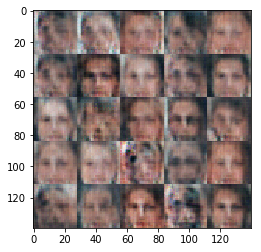

Epoch 2/2..., step 4410 Discriminator Loss: 2.1646... Generator Loss: 2.7717
Epoch 2/2..., step 4420 Discriminator Loss: 0.7325... Generator Loss: 1.8089
Epoch 2/2..., step 4430 Discriminator Loss: 0.3357... Generator Loss: 2.1403
Epoch 2/2..., step 4440 Discriminator Loss: 0.2887... Generator Loss: 6.2570
Epoch 2/2..., step 4450 Discriminator Loss: 0.2998... Generator Loss: 3.9477
Epoch 2/2..., step 4460 Discriminator Loss: 0.2759... Generator Loss: 5.4025
Epoch 2/2..., step 4470 Discriminator Loss: 0.3922... Generator Loss: 3.9271
Epoch 2/2..., step 4480 Discriminator Loss: 0.2447... Generator Loss: 3.7667
Epoch 2/2..., step 4490 Discriminator Loss: 0.3397... Generator Loss: 2.1725
Epoch 2/2..., step 4500 Discriminator Loss: 0.2461... Generator Loss: 4.8160
Epoch 2/2..., step 4510 Discriminator Loss: 0.2750... Generator Loss: 4.8238
Epoch 2/2..., step 4520 Discriminator Loss: 0.2304... Generator Loss: 6.0261
Epoch 2/2..., step 4530 Discriminator Loss: 0.2173... Generator Loss: 6.4264

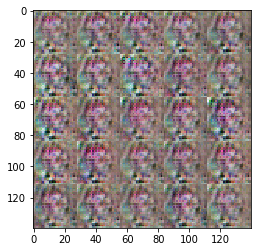

Epoch 2/2..., step 4610 Discriminator Loss: 0.3150... Generator Loss: 5.6939
Epoch 2/2..., step 4620 Discriminator Loss: 0.2176... Generator Loss: 6.2932
Epoch 2/2..., step 4630 Discriminator Loss: 0.2935... Generator Loss: 7.4147
Epoch 2/2..., step 4640 Discriminator Loss: 0.2065... Generator Loss: 7.0555
Epoch 2/2..., step 4650 Discriminator Loss: 0.2081... Generator Loss: 6.3595
Epoch 2/2..., step 4660 Discriminator Loss: 0.2634... Generator Loss: 13.6593
Epoch 2/2..., step 4670 Discriminator Loss: 0.3149... Generator Loss: 6.1378
Epoch 2/2..., step 4680 Discriminator Loss: 0.2871... Generator Loss: 6.4594
Epoch 2/2..., step 4690 Discriminator Loss: 0.3141... Generator Loss: 3.9992
Epoch 2/2..., step 4700 Discriminator Loss: 0.3035... Generator Loss: 8.7868
Epoch 2/2..., step 4710 Discriminator Loss: 0.1739... Generator Loss: 9.1077
Epoch 2/2..., step 4720 Discriminator Loss: 0.2851... Generator Loss: 5.2570
Epoch 2/2..., step 4730 Discriminator Loss: 0.2941... Generator Loss: 7.551

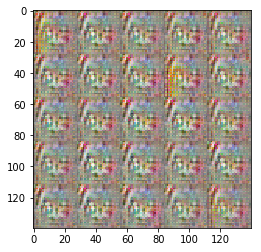

Epoch 2/2..., step 4810 Discriminator Loss: 0.2710... Generator Loss: 9.4732
Epoch 2/2..., step 4820 Discriminator Loss: 0.3360... Generator Loss: 9.4702
Epoch 2/2..., step 4830 Discriminator Loss: 0.2819... Generator Loss: 8.5202
Epoch 2/2..., step 4840 Discriminator Loss: 0.3551... Generator Loss: 3.7802
Epoch 2/2..., step 4850 Discriminator Loss: 0.2937... Generator Loss: 10.3478
Epoch 2/2..., step 4860 Discriminator Loss: 0.2642... Generator Loss: 4.3031
Epoch 2/2..., step 4870 Discriminator Loss: 0.2818... Generator Loss: 8.5908
Epoch 2/2..., step 4880 Discriminator Loss: 0.3253... Generator Loss: 6.9995
Epoch 2/2..., step 4890 Discriminator Loss: 0.2494... Generator Loss: 8.7976
Epoch 2/2..., step 4900 Discriminator Loss: 0.3044... Generator Loss: 4.9895
Epoch 2/2..., step 4910 Discriminator Loss: 0.2818... Generator Loss: 10.5514
Epoch 2/2..., step 4920 Discriminator Loss: 0.2930... Generator Loss: 7.4412
Epoch 2/2..., step 4930 Discriminator Loss: 0.2603... Generator Loss: 9.52

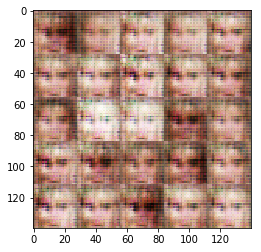

Epoch 2/2..., step 5010 Discriminator Loss: 0.6422... Generator Loss: 1.2621
Epoch 2/2..., step 5020 Discriminator Loss: 0.7029... Generator Loss: 1.1809
Epoch 2/2..., step 5030 Discriminator Loss: 0.9475... Generator Loss: 6.6594
Epoch 2/2..., step 5040 Discriminator Loss: 0.3118... Generator Loss: 7.1449
Epoch 2/2..., step 5050 Discriminator Loss: 0.3222... Generator Loss: 4.3512
Epoch 2/2..., step 5060 Discriminator Loss: 0.3328... Generator Loss: 3.7041
Epoch 2/2..., step 5070 Discriminator Loss: 0.7156... Generator Loss: 0.9401
Epoch 2/2..., step 5080 Discriminator Loss: 0.2910... Generator Loss: 3.8736
Epoch 2/2..., step 5090 Discriminator Loss: 0.2126... Generator Loss: 3.7310
Epoch 2/2..., step 5100 Discriminator Loss: 0.3146... Generator Loss: 6.9430
Epoch 2/2..., step 5110 Discriminator Loss: 0.3070... Generator Loss: 4.9400
Epoch 2/2..., step 5120 Discriminator Loss: 0.2712... Generator Loss: 7.5867
Epoch 2/2..., step 5130 Discriminator Loss: 0.1953... Generator Loss: 9.2819

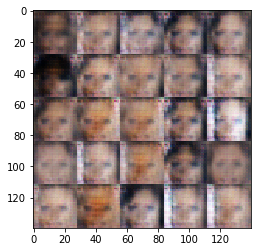

Epoch 2/2..., step 5210 Discriminator Loss: 2.6501... Generator Loss: 0.2307
Epoch 2/2..., step 5220 Discriminator Loss: 3.2821... Generator Loss: 6.4751
Epoch 2/2..., step 5230 Discriminator Loss: 0.4075... Generator Loss: 4.5455
Epoch 2/2..., step 5240 Discriminator Loss: 1.6389... Generator Loss: 0.3698
Epoch 2/2..., step 5250 Discriminator Loss: 0.6312... Generator Loss: 1.0309
Epoch 2/2..., step 5260 Discriminator Loss: 0.3746... Generator Loss: 2.1981
Epoch 2/2..., step 5270 Discriminator Loss: 1.9289... Generator Loss: 0.4090
Epoch 2/2..., step 5280 Discriminator Loss: 1.1037... Generator Loss: 0.5398
Epoch 2/2..., step 5290 Discriminator Loss: 0.3014... Generator Loss: 3.5014
Epoch 2/2..., step 5300 Discriminator Loss: 2.2199... Generator Loss: 2.1908
Epoch 2/2..., step 5310 Discriminator Loss: 0.5481... Generator Loss: 1.3850
Epoch 2/2..., step 5320 Discriminator Loss: 0.3509... Generator Loss: 3.3187
Epoch 2/2..., step 5330 Discriminator Loss: 0.2967... Generator Loss: 3.6130

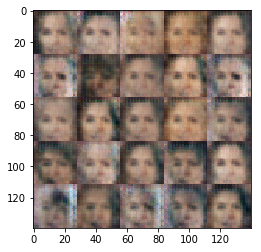

Epoch 2/2..., step 5410 Discriminator Loss: 1.2243... Generator Loss: 0.8175
Epoch 2/2..., step 5420 Discriminator Loss: 0.9568... Generator Loss: 1.4852
Epoch 2/2..., step 5430 Discriminator Loss: 1.0602... Generator Loss: 0.8514
Epoch 2/2..., step 5440 Discriminator Loss: 0.9264... Generator Loss: 0.9909
Epoch 2/2..., step 5450 Discriminator Loss: 0.3451... Generator Loss: 2.4136
Epoch 2/2..., step 5460 Discriminator Loss: 0.6430... Generator Loss: 1.7134
Epoch 2/2..., step 5470 Discriminator Loss: 0.8873... Generator Loss: 0.8254
Epoch 2/2..., step 5480 Discriminator Loss: 0.2979... Generator Loss: 5.6083
Epoch 2/2..., step 5490 Discriminator Loss: 0.8993... Generator Loss: 0.8822
Epoch 2/2..., step 5500 Discriminator Loss: 2.3142... Generator Loss: 2.6629
Epoch 2/2..., step 5510 Discriminator Loss: 1.1330... Generator Loss: 0.7753
Epoch 2/2..., step 5520 Discriminator Loss: 0.5922... Generator Loss: 1.1576
Epoch 2/2..., step 5530 Discriminator Loss: 0.3824... Generator Loss: 2.3051

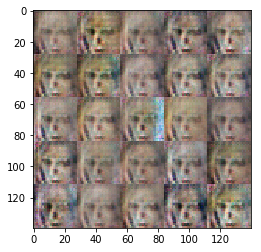

Epoch 2/2..., step 5610 Discriminator Loss: 0.3299... Generator Loss: 5.6688
Epoch 2/2..., step 5620 Discriminator Loss: 0.1996... Generator Loss: 5.6759
Epoch 2/2..., step 5630 Discriminator Loss: 0.3348... Generator Loss: 5.0016
Epoch 2/2..., step 5640 Discriminator Loss: 7.2696... Generator Loss: 6.5582
Epoch 2/2..., step 5650 Discriminator Loss: 0.3665... Generator Loss: 2.1542
Epoch 2/2..., step 5660 Discriminator Loss: 0.3502... Generator Loss: 2.8140
Epoch 2/2..., step 5670 Discriminator Loss: 0.6688... Generator Loss: 3.0000
Epoch 2/2..., step 5680 Discriminator Loss: 0.2959... Generator Loss: 4.2683
Epoch 2/2..., step 5690 Discriminator Loss: 1.4033... Generator Loss: 5.5702
Epoch 2/2..., step 5700 Discriminator Loss: 1.6635... Generator Loss: 7.6607
Epoch 2/2..., step 5710 Discriminator Loss: 0.3500... Generator Loss: 2.5797
Epoch 2/2..., step 5720 Discriminator Loss: 0.3215... Generator Loss: 3.3980
Epoch 2/2..., step 5730 Discriminator Loss: 0.3938... Generator Loss: 1.3761

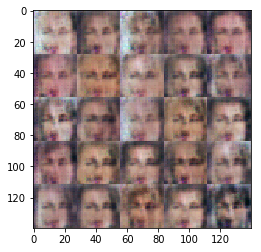

Epoch 2/2..., step 5810 Discriminator Loss: 1.1423... Generator Loss: 0.5456
Epoch 2/2..., step 5820 Discriminator Loss: 0.5236... Generator Loss: 2.5007
Epoch 2/2..., step 5830 Discriminator Loss: 0.3429... Generator Loss: 2.6398
Epoch 2/2..., step 5840 Discriminator Loss: 0.9503... Generator Loss: 1.4323
Epoch 2/2..., step 5850 Discriminator Loss: 0.8662... Generator Loss: 1.5761
Epoch 2/2..., step 5860 Discriminator Loss: 0.5832... Generator Loss: 3.2269
Epoch 2/2..., step 5870 Discriminator Loss: 0.4407... Generator Loss: 1.5482
Epoch 2/2..., step 5880 Discriminator Loss: 0.2260... Generator Loss: 3.4797
Epoch 2/2..., step 5890 Discriminator Loss: 0.3375... Generator Loss: 7.0871
Epoch 2/2..., step 5900 Discriminator Loss: 0.3232... Generator Loss: 6.2696
Epoch 2/2..., step 5910 Discriminator Loss: 0.3240... Generator Loss: 3.7716
Epoch 2/2..., step 5920 Discriminator Loss: 0.3105... Generator Loss: 3.9265
Epoch 2/2..., step 5930 Discriminator Loss: 0.5778... Generator Loss: 1.3328

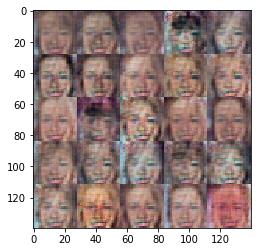

Epoch 2/2..., step 6010 Discriminator Loss: 0.2846... Generator Loss: 6.3596
Epoch 2/2..., step 6020 Discriminator Loss: 0.2945... Generator Loss: 10.6192
Epoch 2/2..., step 6030 Discriminator Loss: 0.2697... Generator Loss: 3.0910
Epoch 2/2..., step 6040 Discriminator Loss: 1.0552... Generator Loss: 4.7638
Epoch 2/2..., step 6050 Discriminator Loss: 0.4962... Generator Loss: 1.7564
Epoch 2/2..., step 6060 Discriminator Loss: 1.5388... Generator Loss: 0.5628
Epoch 2/2..., step 6070 Discriminator Loss: 0.8714... Generator Loss: 0.7542
Epoch 2/2..., step 6080 Discriminator Loss: 0.3532... Generator Loss: 2.8670
Epoch 2/2..., step 6090 Discriminator Loss: 0.8886... Generator Loss: 2.2174
Epoch 2/2..., step 6100 Discriminator Loss: 0.4111... Generator Loss: 3.1572
Epoch 2/2..., step 6110 Discriminator Loss: 1.5497... Generator Loss: 0.3182
Epoch 2/2..., step 6120 Discriminator Loss: 1.8061... Generator Loss: 1.3969
Epoch 2/2..., step 6130 Discriminator Loss: 0.8315... Generator Loss: 2.238

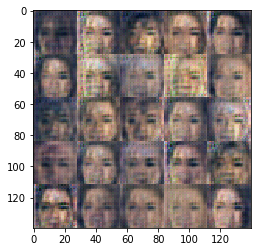

Epoch 2/2..., step 6210 Discriminator Loss: 0.2897... Generator Loss: 6.2480
Epoch 2/2..., step 6220 Discriminator Loss: 0.3863... Generator Loss: 1.5761
Epoch 2/2..., step 6230 Discriminator Loss: 1.9265... Generator Loss: 0.3171
Epoch 2/2..., step 6240 Discriminator Loss: 0.7077... Generator Loss: 2.9688
Epoch 2/2..., step 6250 Discriminator Loss: 0.6128... Generator Loss: 3.4651
Epoch 2/2..., step 6260 Discriminator Loss: 0.6226... Generator Loss: 1.2002
Epoch 2/2..., step 6270 Discriminator Loss: 1.1674... Generator Loss: 4.4921
Epoch 2/2..., step 6280 Discriminator Loss: 0.2524... Generator Loss: 2.6688
Epoch 2/2..., step 6290 Discriminator Loss: 0.3156... Generator Loss: 3.9893
Epoch 2/2..., step 6300 Discriminator Loss: 0.2194... Generator Loss: 2.6523
Epoch 2/2..., step 6310 Discriminator Loss: 0.2563... Generator Loss: 5.2691
Epoch 2/2..., step 6320 Discriminator Loss: 0.2268... Generator Loss: 6.7511
Epoch 2/2..., step 6330 Discriminator Loss: 0.4065... Generator Loss: 1.5564

In [39]:
batch_size = 64
z_dim = 100
learning_rate = .005
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.